# Compare
1. BPR: Bayesian Personalized Ranking from Implicit Feedback
https://arxiv.org/abs/1205.2618
2. (WARP) WSABIE: Scaling Up To Large Vocabulary Image Annotation http://www.thespermwhale.com/jaseweston/papers/wsabie-ijcai.pdf
3. (k-OS WARP) Learning to Rank Recommendations with the k-Order Statistic Loss https://research.google.com/pubs/pub41534.html
4. CLiMF: Learning to Maximize Reciprocal Rank with Collaborative Less-is-More Filtering
http://baltrunas.info/papers/Shi12-climf.pdf

### Data
- Movielens 100k https://grouplens.org/datasets/movielens/100k/
- README - http://files.grouplens.org/datasets/movielens/ml-100k-README.txt

In [1]:
import os
import pandas as pd
from scipy.sparse import coo_matrix, csr_matrix, diags
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import log_loss, accuracy_score, roc_curve, roc_auc_score
from sklearn.utils.extmath import safe_sparse_dot
import time
import math

%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from warp import WARPNaive, KosWARP
from bpr import BPR
from climf import CLiMF

In [4]:
dtype = np.float32

In [5]:
data_dir = "/Users/timwee/projects/datasets/movielens/ml-100k"

def load_data_from_f(fpath):
    # columns - user id | item id | rating | timestamp
    # user_id and item_id numbered consecutively from 1
    with open(fpath) as f:
        users, items, ratings = [], [], []
        max_user = -1
        max_item = -1
        for line in f:
            user_id, item_id, rating, ts = [int(tok) for tok in line.strip().split("\t")]
            # make it zero indexed
            user_id -= 1
            item_id -= 1
            max_user = max(max_user, user_id)
            max_item = max(max_item, item_id)
            users.append(user_id) 
            items.append(item_id)
            ratings.append(rating)
        return np.array(users), np.array(items), np.array(ratings), max_user, max_item


def train_and_test_data(data_dir, train_fname="ua.base", test_fname="ua.test", dtype=np.float32):
    trn_u, trn_i, trn_r, max_trn_u, max_trn_i = load_data_from_f(os.path.join(data_dir, train_fname))
    tst_u, tst_i, tst_r, max_tst_u, max_tst_i = load_data_from_f(os.path.join(data_dir, test_fname))
    num_rows = max(max_trn_u, max_tst_u) + 1
    num_cols = max(max_trn_i, max_tst_i) + 1
    return {"train" : coo_matrix((trn_r, (trn_u, trn_i)), shape=(num_rows, num_cols), dtype=dtype).tocsr(), \
            "test" : coo_matrix((tst_r, (tst_u, tst_i)), shape=(num_rows, num_cols), dtype=dtype).tocsr()}
    

In [6]:
movielens = train_and_test_data(data_dir, dtype=dtype)
train, test = movielens["train"], movielens["test"]
num_users, num_items = train.shape
train.shape, test.shape

((943, 1682), (943, 1682))

### learning rate decay

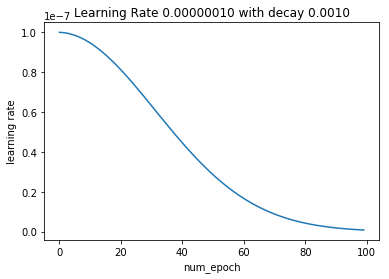

In [7]:
lrate = 1e-7
decay = 1e-3
lr_val = [lrate]
for i in range(1, 100):
    lr_val.append(lr_val[i-1] * (1. / (1. + (decay * i))))
plt.plot(np.arange(100), lr_val)
plt.xlabel("num_epoch")
plt.ylabel("learning rate")
plt.title("Learning Rate %.8f with decay %.4f" % (lrate, decay))
plt.show()

## helpers

In [8]:
def plot_auc(title, auc_scores, num_epochs):
    epoch_x = np.arange(num_epochs)
    test_line, = plt.plot(epoch_x, auc_scores, label="auc test")
    plt.legend([test_line], ["test auc"])
    plt.xlabel("num_epoch")
    plt.ylabel("auc_score")
    plt.title(title)
    plt.show()

In [21]:
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k, reciprocal_rank

In [10]:
num_epochs = 100
eval_interval = 10

# KOS Warp

In [11]:
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k

durations = []
tst_koswarp_auc = []
tst_koswarp_prec5 = []
tst_koswarp_rr = []

kos_model = KosWARP(lr=5e-7, item_reg=0.2, user_reg=0.2)
for epoch in range(num_epochs):
    start = time.time()
    kos_model.fit(train, reset=False)
    if (epoch % eval_interval) == 0 or epoch == num_epochs:
        duration = time.time() - start
        durations.append(duration)    
        tst_auc = auc_score(kos_model, test, train_interactions=train).mean()
        tst_prec5 = precision_at_k(kos_model, test, train_interactions=train, k=5).mean()
        tst_rr = reciprocal_rank(kos_model, test, train_interactions=train).mean()
        tst_koswarp_auc.append(tst_auc)
        tst_koswarp_prec5.append(tst_prec5)
        tst_koswarp_rr.append(tst_rr)
        print("iteration %d took %.4f, auc: %.4f, p@5: %.4f, rr: %.4f" % \
              (epoch, duration, tst_auc, tst_prec5, tst_rr))

initializing embeddings and biases
iteration 0 took 10.1572, auc: 0.6801, p@5: 0.0358, rr: 0.1190
iteration 10 took 9.9758, auc: 0.8240, p@5: 0.0545, rr: 0.1570
iteration 20 took 10.2068, auc: 0.8269, p@5: 0.0520, rr: 0.1595
iteration 30 took 9.9860, auc: 0.8280, p@5: 0.0530, rr: 0.1599
iteration 40 took 8.6569, auc: 0.8272, p@5: 0.0528, rr: 0.1567
iteration 50 took 10.1499, auc: 0.8279, p@5: 0.0515, rr: 0.1625
iteration 60 took 10.0506, auc: 0.8277, p@5: 0.0534, rr: 0.1581
iteration 70 took 9.6062, auc: 0.8267, p@5: 0.0541, rr: 0.1593
iteration 80 took 9.9244, auc: 0.8269, p@5: 0.0534, rr: 0.1565
iteration 90 took 10.3313, auc: 0.8274, p@5: 0.0503, rr: 0.1552


# CLiMF

In [20]:
durations = []
tst_climf_auc = []
tst_climf_prec5 = []
tst_climf_rr = []

# override lr
lrate = 1e-4
decay = 5e-4

climf_model = CLiMF(lr=1e-4, reg=0.001)
for epoch in range(num_epochs+1):
    start = time.time()
    climf_model.fit(train, lr=lrate, debug=False, reset=False)
    lrate *= (1. / (1. + (decay * i)))
    duration = time.time() - start
    if (epoch % eval_interval) == 0 or epoch == num_epochs:
        durations.append(duration)    
        tst_auc = auc_score(climf_model, test, train_interactions=train).mean()
        tst_prec5 = precision_at_k(climf_model, test, train_interactions=train, k=5).mean()
        tst_rr = reciprocal_rank(climf_model, test, train_interactions=train).mean()
        tst_climf_auc.append(tst_auc)
        tst_climf_prec5.append(tst_prec5)
        tst_climf_rr.append(tst_rr)
        print("iteration %d took %.4f, auc: %.4f, p@5: %.4f, rr: %.4f" % \
              (epoch, duration, tst_auc, tst_prec5, tst_rr))

initializing embeddings
iteration 0 took 15.8728, auc: 0.5065, p@5: 0.0038, rr: 0.0269
iteration 10 took 15.6864, auc: 0.5125, p@5: 0.0172, rr: 0.0609
iteration 20 took 15.3678, auc: 0.5428, p@5: 0.0252, rr: 0.0841
iteration 30 took 15.3780, auc: 0.5767, p@5: 0.0358, rr: 0.1148
iteration 40 took 12.8061, auc: 0.6022, p@5: 0.0441, rr: 0.1308
iteration 50 took 17.5118, auc: 0.6188, p@5: 0.0501, rr: 0.1456
iteration 60 took 16.8228, auc: 0.6292, p@5: 0.0530, rr: 0.1534
iteration 70 took 13.8082, auc: 0.6356, p@5: 0.0551, rr: 0.1588
iteration 80 took 15.3527, auc: 0.6396, p@5: 0.0566, rr: 0.1610
iteration 90 took 15.9507, auc: 0.6419, p@5: 0.0583, rr: 0.1631


In [13]:
durations = []
tst_warp_auc = []
tst_warp_prec5 = []
tst_warp_rr = []


model = WARPNaive(lr=5e-7, item_reg=0.2, user_reg=0.2)

for epoch in range(num_epochs):
    start = time.time()
    model.fit(train, reset=False)
    if (epoch % eval_interval) == 0 or epoch == num_epochs:
        duration = time.time() - start
        durations.append(duration)    
        tst_auc = auc_score(model, test, train_interactions=train).mean()
        tst_prec5 = precision_at_k(model, test, train_interactions=train, k=5).mean()
        tst_rr = reciprocal_rank(model, test, train_interactions=train).mean()
        tst_warp_auc.append(tst_auc)
        tst_warp_prec5.append(tst_prec5)
        tst_warp_rr.append(tst_rr)
        print("warp iteration %d took %.4f, auc: %.4f, p@5: %.4f, rr: %.4f" % \
              (epoch, duration, tst_auc, tst_prec5, tst_rr))

initializing embeddings and biases
warp iteration 0 took 4.6919, auc: 0.6278, p@5: 0.0301, rr: 0.0989
warp iteration 10 took 4.8835, auc: 0.7660, p@5: 0.0422, rr: 0.1345
warp iteration 20 took 4.6438, auc: 0.7841, p@5: 0.0428, rr: 0.1520
warp iteration 30 took 4.7636, auc: 0.7907, p@5: 0.0422, rr: 0.1570
warp iteration 40 took 4.7492, auc: 0.7942, p@5: 0.0418, rr: 0.1588
warp iteration 50 took 4.7112, auc: 0.7961, p@5: 0.0416, rr: 0.1594
warp iteration 60 took 4.7236, auc: 0.7970, p@5: 0.0418, rr: 0.1587
warp iteration 70 took 4.6846, auc: 0.7976, p@5: 0.0416, rr: 0.1591
warp iteration 80 took 4.7790, auc: 0.7980, p@5: 0.0416, rr: 0.1588
warp iteration 90 took 4.7312, auc: 0.7981, p@5: 0.0416, rr: 0.1588


## BPR Class

In [16]:
durations = []
tst_bpr_auc = []
tst_bpr_prec5 = []
tst_bpr_rr = []

bpr_model = BPR(lr=5e-7, item_reg=0.2, user_reg=0.2)
for epoch in range(num_epochs):
    start = time.time()
    bpr_model.fit(train, reset=False)
    if (epoch % eval_interval) == 0 or epoch == num_epochs:
        duration = time.time() - start
        durations.append(duration)    
        tst_auc = auc_score(bpr_model, test, train_interactions=train).mean()
        tst_prec5 = precision_at_k(bpr_model, test, train_interactions=train, k=5).mean()
        tst_rr = reciprocal_rank(bpr_model, test, train_interactions=train).mean()
        tst_bpr_auc.append(tst_auc)
        tst_bpr_prec5.append(tst_prec5)
        tst_bpr_rr.append(tst_rr)
        print("iteration %d took %.4f, auc: %.4f, p@5: %.4f, rr: %.4f" % (epoch, duration, tst_auc, tst_prec5, tst_rr))

initializing embeddings and biases
iteration 0 took 5.4106, auc: 0.5177, p@5: 0.0072, rr: 0.0352
iteration 10 took 5.3620, auc: 0.6187, p@5: 0.0288, rr: 0.0976
iteration 20 took 5.3111, auc: 0.6698, p@5: 0.0335, rr: 0.1045
iteration 30 took 5.3280, auc: 0.7032, p@5: 0.0337, rr: 0.1095
iteration 40 took 5.3624, auc: 0.7270, p@5: 0.0354, rr: 0.1123
iteration 50 took 5.3010, auc: 0.7441, p@5: 0.0388, rr: 0.1198
iteration 60 took 5.2681, auc: 0.7568, p@5: 0.0397, rr: 0.1284
iteration 70 took 5.2721, auc: 0.7668, p@5: 0.0414, rr: 0.1341
iteration 80 took 5.3762, auc: 0.7741, p@5: 0.0416, rr: 0.1424
iteration 90 took 5.3329, auc: 0.7799, p@5: 0.0416, rr: 0.1483


# compare algos

### reciprocal rank

Note: CLiMF optimizes for Reciprocal Rank directly.

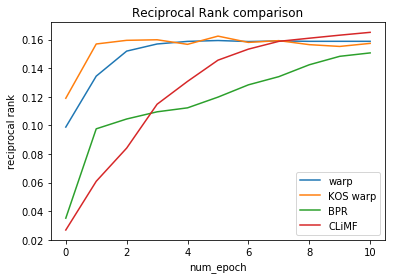

In [31]:
epoch_x = np.arange(len(tst_warp_rr))
warp_line, = plt.plot(epoch_x, tst_warp_rr, label="WARP")
koswarp_line, = plt.plot(epoch_x, tst_koswarp_rr, label="KOS WARP")
bpr_line, = plt.plot(epoch_x, tst_bpr_rr, label="BPR")
climf_line, = plt.plot(epoch_x, tst_climf_rr, label="CLiMF")
plt.legend([warp_line, koswarp_line, bpr_line, climf_line], \
           ["warp", "KOS warp", "BPR", "CLiMF"])
plt.xlabel("num_epoch")
plt.ylabel("reciprocal rank")
plt.title("Reciprocal Rank comparison")
plt.show()

### P@5

WARP and k-OS WARP optimize for p@5. 

Reciprocal rank is somewhat related to it too, since it optimizes for the top of the list.

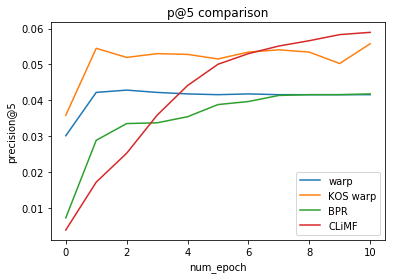

In [30]:
epoch_x = np.arange(len(tst_warp_prec5))
warp_line, = plt.plot(epoch_x, tst_warp_prec5, label="WARP")
koswarp_line, = plt.plot(epoch_x, tst_koswarp_prec5, label="KOS WARP")
bpr_line, = plt.plot(epoch_x, tst_bpr_prec5, label="BPR")
climf_line, = plt.plot(epoch_x, tst_climf_prec5, label="CLiMF")
plt.legend([warp_line, koswarp_line, bpr_line, climf_line], \
           ["warp", "KOS warp", "BPR", "CLiMF"])
plt.xlabel("num_epoch")
plt.ylabel("precision@5")
plt.title("p@5 comparison")
plt.show()

### AUC

BPR optimizes for AUC, CLiMF does not. (AUC optimizes across the entire list, reciprocal rank is for the top of the list)

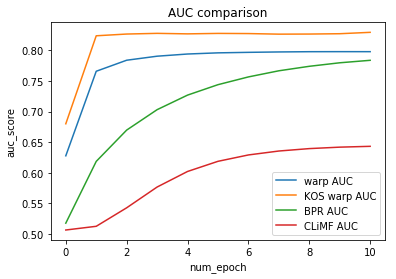

In [28]:
epoch_x = np.arange(len(tst_warp_auc))
warp_line, = plt.plot(epoch_x, tst_warp_auc, label="WARP")
koswarp_line, = plt.plot(epoch_x, tst_koswarp_auc, label="KOS WARP")
bpr_line, = plt.plot(epoch_x, tst_bpr_auc, label="BPR")
climf_line, = plt.plot(epoch_x, tst_climf_auc, label="CLiMF")
plt.legend([warp_line, koswarp_line, bpr_line, climf_line], \
           ["warp AUC", "KOS warp AUC", "BPR AUC", "CLiMF AUC"])
plt.xlabel("num_epoch")
plt.ylabel("auc_score")
plt.title("AUC comparison")
plt.show()